# ch08. 경사하강법 (gradient descent)

데이터 과학을 하다 보면 특정 상황에 **가장 적합**한 모델을 찾아야 할 때가 많다.
* 가장 적합한(best) == `모델의 오류를 최소화 하는`, `likelihood(우도)를 최대화하는`
* 어떤 최적화 문제에 대한 답을 찾는 것

> [likelihood 가능도?](http://rstudio-pubs-static.s3.amazonaws.com/204928_c2d6c62565b74a4987e935f756badfba.html) PDF에서의 y값 

## 목차
* [8.1 경사 하강법에 숨은 의미](#8.1-경사-하강법에-숨은-의미)
* [8.2 Gradient 계산하기](#8.2-Gradient-계산하기)
* [8.3 Gradient 적용하기](#8.3-Gradient-적용하기)
* [8.4 적절한 이동 거리 정하기](#8.4-적절한-이동-거리-정하기)
* [8.5 종합하기](#8.5-종합하기)
* [8.6 SGD(stochastic gradient descent)](#8.6-SGD(stochastic-gradient-descent))
* [8.7 더 공부해 보고 싶다면](#8.7-더-공부해-보고-싶다면)


In [1]:
# importing cell
import random
import math
import numpy as np
import matplotlib.pyplot as plt

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))  

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

## 8.1 경사 하강법에 숨은 의미
실수 벡터를 입력하면 실수 하나를 출력해 주는 함수 f가 있다고 해보자.
그리고 이 함수의 최대(혹은 최소)값을 찾아야 한다면,
1. 임의의 지점을 정한다.
2. 해당 지점에서 함수의 gradient를 구한다.
    * gradient(경사, 기울기)는 함수가 가장 빠르게 증가할 수 있는 방향
    * gradient는 편미분 벡터
3. gradient의 방향으로 조금 이동한다.
4. 최대/최소값에 도달하지 않았다면 2로 이동 후 반복한다.
> 이 방법은 함수 하나의 전역 최솟값(global minimum)이 존재하는 경우 확실한 결과를 보장한다. 하지만 함수에 지역 최솟값(local minimum)이 여러 개 있는 경우에는 시작점을 어디로 잡느냐에 따라 잘못된 곳으로 빠질 수 있다. 그런 경우에는, 기존의 점과 다른 다양한 시작점에서 경사 하강법을 사용해 볼 수 있다. 만일 최소값이 존재하지 않는다면, 이 과정은 영원히 끝나지 않을 수도 있다.


In [2]:
def sum_of_squares(v):
    """v에 속해 있는 항목들의 제곱합을 계산한다."""
    return sum(v_i ** 2 for v_i in v)

vector = [i for i in range(10)]
r1 = sum_of_squares(vector)
r2 = np.sum(np.square(vector))
print("r1:", r1, ", r2:", r2)

r1: 285 , r2: 285


## 8.2 Gradient 계산하기

f가 단변수 함수인 경우, 
* 점 x에서의 미분값 : x가 아주 조금 변했을 때 f(x)의 변화량
$$ \lim_{h->0}\frac{f(x + h) - f(x)}{h} $$

* 도함수(deivative) 
$$ f^\prime(x) = \lim_{h->0}\frac{f(x + h) - f(x)}{h} $$

> 점 x의 적당한 근방에서 정의된 함수 f에 대하여, 극한값이 존재하는 경우에, 
f는 x에서 미분가능하다(differentiable)고 하고, 극한값을 f의 x에서의 도함수(derivative)라고 하며, $ f^\prime(x)$로 나타낸다.

f가 다변수 함수라면, 
* f(x)의 변화량을 알려주는 편도함수(partial derivative) 역시 여러 개 존재한다.
$$ \frac{\partial f}{\partial x} = f_x(x, y, z) = \lim_{h->0}\frac{f(x + h,y,z) - f(x,y,z)}{h} $$ 
$$ \frac{\partial f}{\partial y} = f_y(x, y, z) = \lim_{h->0}\frac{f(x,y + h,z) - f(x,y,z)}{h} $$
$$ \frac{\partial f}{\partial z} = f_z(x, y, z) = \lim_{h->0}\frac{f(x,y,z + h) - f(x,y,z)}{h} $$

* gradient
$$ \nabla f(\boldsymbol x) = \frac{\partial f}{\partial x}(\boldsymbol x)\boldsymbol i + \frac{\partial f}{\partial y}(\boldsymbol x)\boldsymbol j + \frac{\partial f}{\partial z}(\boldsymbol x)\boldsymbol k $$

In [3]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

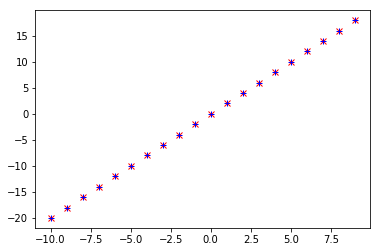

In [6]:
def plot_estimated_derivative():
    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

    # 두 계산식에 따른 결과값이 거의 비슷함을 보여 주기 위한 그래프
    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx')           # red  x
    plt.plot(x, list(map(derivative_estimate, x)), 'b+')  # blue +
    plt.show()

plot_estimated_derivative()

In [7]:
def partial_difference_quotient(f, v, i, h):
    """함수 f의 i번째 편도함수가 v에서 가지는 값"""
    w = [v_j + (h if j == i else 0)    # h를 v의 i번째 변수에만 더해주자
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

> 함수 두 값의 차이를 사용해서 근사하는 것의 가장 큰 단점은 계산 비용이 크다는 것이다.  
v의 길이가 n이면 estimate_gradient함수는 f를 2n번 계산해야 한다.  
따라서 빈번하게 계산하는 경우, 불필요한 계산도 많이 하게된다.

## 8.3 Gradient 적용하기
* `sum_of_aquares`는 v가 0벡터일 때 가장 작은 값을 가진다. 
* 이 사실을 모른다고 가정하고, 경사 하강법을 이용해 **3차원 벡터**의 최솟값을 구하는 예제
    * 임의의 시작점을 잡고, gradient가 아주 작아질 때까지 경사의 반대 방향으로 조금씩 이동

In [9]:
def step(v, direction, step_size):
    """v에서 step_size만큼 이동하기"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

In [20]:
print("using the gradient")
# 임의의 시작점을 선택
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001

while True:
    #print v, sum_of_squares(v)
    gradient = sum_of_squares_gradient(v)   # v의 gradient 계산
    next_v = step(v, gradient, -0.0001)     # 경사도의 음수만큼 이동
    if distance(next_v, v) < tolerance:     # tolerance에 수렴하게 되면 멈춤
        break
    v = next_v                              # 아니면 계속 반복

print("minimum v", v)
print("minimum value", sum_of_squares(v))


using the gradient
minimum v [0.00029094373074783095, 0.0003636796634347929, 0.00018183983171739644]
minimum value 2.4997687645652166e-07
2.249e-05


## 8.4 적절한 이동 거리 정하기
경사를 따라 이동한다는 논리는 명백하지만, 이동 거리(step size)를 정하는 것은 그렇지 않다.  
실제로 이동거리를 정하는 것은 과학보다는 기술(art)에 가깝다.  
몇 가지 일반적인 옵션은,
* 이동 거리를 고정
* 시간에 따라 이동 거리를 점차 줄임
* 이동할 때마다 목적 함수를 최소화하는 이동 거리로 정함
    * 전체를 다 계산하기에는 계산 비용이 크므로 몇몇 정해진 이동 거리를 시도해 보고 그 중에 작은 값으로 정하는 방법이 있다.
    * e.g. ) `step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]`
    * 이 step_sizes 계산 결과의 몇몇은 오류를 발생시킬 수도 있으므로 아래와 같이 safe함수로 wrapping하는 방법을 적용할 수 있다. 

In [25]:
def safe(f):
    """f와 똑같은 함수를 반환하지만 f에 오류가 발생하면 무한대를 반환해준다"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

## 8.5 종합하기

In [26]:
#
#
# minimize / maximize batch
#
#

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """목적 함수를 최소화시키는 theta를 경사 하강법을 사용해서 찾아준다."""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # theta를 시작점으로 설정
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # 함수를 최소화 시키는 theta 선택
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # tolerance만큼 수렴하면 멈춤
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

def negate(f):
    """x를 입력하면 -f(x)를 반환해 주는 함수 생성"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """f가 여러 숫자를 반환할 때 모든 숫자를 음수로 변환"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

In [27]:
print("using minimize_batch")
v = [random.randint(-10,10) for i in range(3)]
print (v)
v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

print("minimum v", v)
print("minimum value", sum_of_squares(v))

using minimize_batch
[-4, -6, -5]
minimum v [-0.0006646139978924582, -0.0009969209968386874, -0.0008307674973655728]
minimum value 2.1257378748114955e-06


## 8.6 SGD(stochastic gradient descent) 

In [19]:
#
# minimize / maximize stochastic
#

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

In [20]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [21]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

In [22]:
# Test를 위한 예제들은 이후 ch14 등에서 제시됨, 현재 코드만으로는 활용에 대해 이해하기 어려우니 skip 할 것을 추천

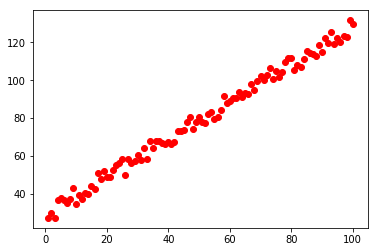

In [23]:
# Numpy version from : http://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy

def genData(numPoints, bias, variance):
    x = np.zeros(shape=(numPoints, 2))
    y = np.zeros(shape=numPoints)
    # basically a straight line
    for i in range(0, numPoints):
        # bias feature
        x[i][0] = 1
        x[i][1] = i
        # our target variable
        y[i] = (i+bias) + random.uniform(0, 1) * variance
    return x, y

# gen 100 points with a bias of 25 and 10 variance as a bit of noise
x, y = genData(100, 25, 10)

plt.plot(x[:,1]+1,y,"ro")
plt.show()

In [24]:
# m denotes the number of examples here, not the number of features
def gradientDescent(x, y, theta, alpha, m, numIterations):
    xTrans = x.transpose()
    theta_list = []
    for i in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        
        # avg cost per example (the 2 in 2*m doesn't really matter here.
        # But to be consistent with the gradient, I include it)
        cost = np.sum(loss ** 2) / (2 * m)
        
        gradient = np.dot(xTrans, loss) / m
        # update
        theta = theta - alpha * gradient
        if i % 2500 == 0:
            theta_list.append(theta)
    return theta,np.array(theta_list)

m, n = np.shape(x)
numIterations= 50000
alpha = 0.0005
x.transpose()
theta = np.ones(n)
theta,theta_list = gradientDescent(x, y, theta, alpha, m, numIterations)

theta

array([ 30.41583494,   0.98721297])

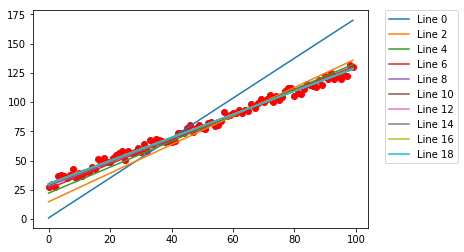

In [25]:
y_predict_step= np.dot(x, theta_list.transpose())
plt.plot(x[:,1],y,"ro")
for i in range (0,20,2):
    plt.plot(x[:,1],y_predict_step[:,i], label='Line %d'%i)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

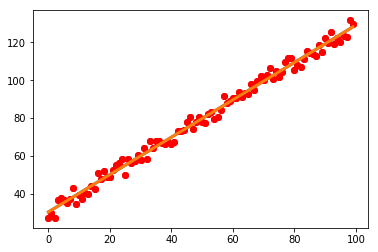

In [27]:
y_predict= np.dot(x, theta)

plt.plot(x[:,1],y,"ro")
plt.plot(x[:,1],y_predict, lw=3)
plt.show()

## 8.7 더 공부해 보고 싶다면
* 계속 읽어 나가자! 이 책에서 문제를 풀면서 경사 하강법을 꾸준하게 사용할 것이다. (ch14)
* 책 추천 : [Active Calulus](http://faculty.gvsu.edu/boelkinm/Home/Download.html) 
    * 일반적인 미적분한 책보다 친철한 편
* `scikit-learn`에도 [SGD 모듈](http://scikit-learn.org/stable/modules/sgd.html)